# RNN


### Import thư viện


In [1]:
# import thư viện
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

## Bitcoin Dataset


In [2]:
file_path = "D:\\github_desktop\\Cryptocurrency-Price-Prediction\\Cryptocurrency\\Dataset\\Ethereum Historical Data.csv"

data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_values('Date', inplace=True)

### Chia 7:3


In [3]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
training_data_len = math.ceil(len(data) * 0.7)
train_data = data[:training_data_len].iloc[:, :2]
test_data = data[training_data_len:].iloc[:, :2]

In [4]:
# Convert 'Price' column to numeric by removing commas
train_data['Price'] = train_data['Price'].str.replace(',', '').astype(float)
test_data['Price'] = test_data['Price'].str.replace(',', '').astype(float)

dataset_train = train_data.Price.values.reshape(-1, 1)
dataset_test = test_data.Price.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

# Tạo tập dữ liệu huấn luyện
X_train, y_train = [], []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Chuẩn bị dữ liệu kiểm tra
last_50_days_train = scaled_train[-50:]
full_test_input = np.concatenate((last_50_days_train, scaled_test), axis=0)
X_test = []
for i in range(50, len(full_test_input)):
    X_test.append(full_test_input[i-50:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Khởi tạo và huấn luyện mô hình RNN
regressor = Sequential()
regressor.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(1, activation=None))

regressor.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

C:\Users\Hii\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


In [ ]:
# Dự đoán với dữ liệu kiểm tra
y_RNN = regressor.predict(X_test)

# Dự đoán cho 30, 60, 90 ngày tiếp theo
def predict_future(days, last_X):
    future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=days, freq='D')
    y_future = []
    
    for date in future_dates:
        next_y = regressor.predict(last_X.reshape(1, -1, 1))
        y_future.append(next_y[0, 0])
        last_X = np.append(last_X[1:], next_y)
        
    y_future = np.array(y_future).reshape(-1, 1)
    y_future_scaled = scaler.inverse_transform(y_future)
    
    return future_dates, y_future_scaled

# Lấy giá trị cuối cùng của X_test làm điểm bắt đầu cho dự đoán
last_X = X_test[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30, y_RNN_30 = predict_future(30, last_X)
# Dự đoán cho 60 ngày tiếp theo sau 30 ngày dự đoán đầu tiên
future_dates_60, y_RNN_60 = predict_future(60, last_X)
# Dự đoán cho 90 ngày tiếp theo sau 60 ngày dự đoán đầu tiên
future_dates_90, y_RNN_90 = predict_future(90, last_X)

# Chuyển đổi các giá trị dự đoán về giá trị gốc
y_RNN_O = scaler.inverse_transform(y_RNN)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━

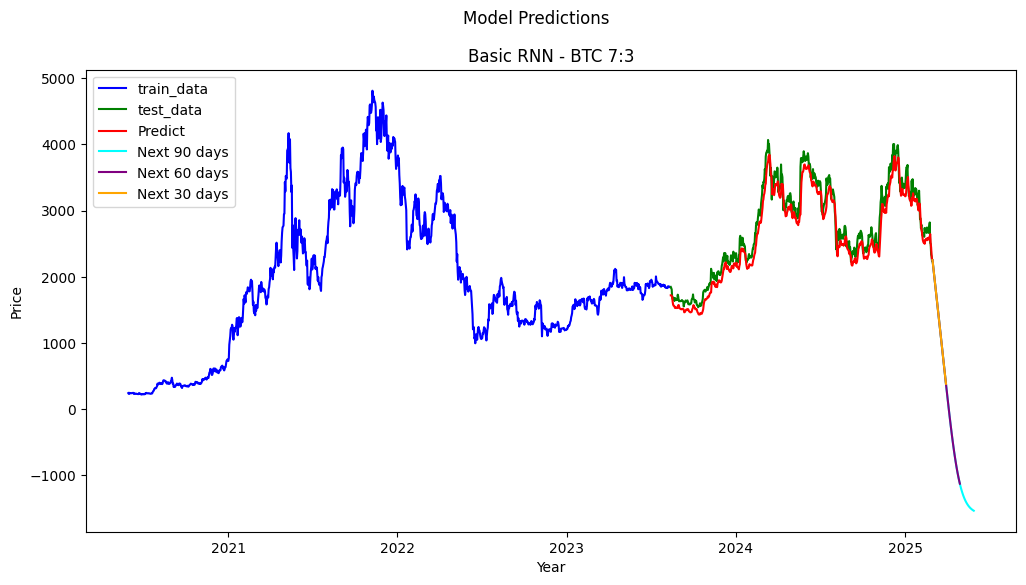

In [ ]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Predictions')

ax.plot(train_data.index[150:], train_data.Price[150:], label="train_data", color="b")
ax.plot(test_data.index, test_data.Price, label="test_data", color="g")
ax.plot(test_data.index, y_RNN_O, label="Predict", color="red")
ax.plot(future_dates_90, y_RNN_90, label="Next 90 days", color="cyan")
ax.plot(future_dates_60, y_RNN_60, label="Next 60 days", color="purple")
ax.plot(future_dates_30, y_RNN_30, label="Next 30 days", color="orange")

ax.legend()
ax.set_title("Basic RNN - BTC 7:3")
ax.set_xlabel("Year")
ax.set_ylabel("Price")

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Tính toán độ đo RMSE, MAPE và MSE
rmse = np.sqrt(mean_squared_error(test_data.Price, y_RNN_O))
mape = mean_absolute_percentage_error(test_data.Price, y_RNN_O) * 100
mse = mean_squared_error(test_data.Price, y_RNN_O)

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape, "%")
print("MSE:", mse)

RMSE: 171.61400335958854
MAPE: 5.570606526705804 %
MSE: 29451.36614910487


### Chia 8:2


### Chia 9:1


In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
training_data_len = math.ceil(len(data) * 0.9)
train_data = data[:training_data_len].iloc[:, :2]
test_data = data[training_data_len:].iloc[:, :2]

In [ ]:
# Remove commas and convert 'Price' column to numeric
train_data['Price'] = train_data['Price'].str.replace(',', '').astype(float)
test_data['Price'] = test_data['Price'].str.replace(',', '').astype(float)

dataset_train = train_data.Price.values.reshape(-1, 1)
dataset_test = test_data.Price.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

# Tạo tập dữ liệu huấn luyện
X_train, y_train = [], []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Chuẩn bị dữ liệu kiểm tra
last_50_days_train = scaled_train[-50:]
full_test_input = np.concatenate((last_50_days_train, scaled_test), axis=0)
X_test = []
for i in range(50, len(full_test_input)):
    X_test.append(full_test_input[i-50:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Khởi tạo và huấn luyện mô hình RNN
regressor = Sequential()
regressor.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(1, activation=None))

regressor.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


C:\Users\Hii\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1007  
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5752e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3464e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0023e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6074e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3506e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4248e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9554e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6681e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0805e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5617e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8735e-04
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2115e-04
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0465e-04
Epoch 15/100
26/26 ━━━━━━━━━━

In [ ]:
# Dự đoán với dữ liệu kiểm tra
y_RNN = regressor.predict(X_test)

# Dự đoán cho 30, 60, 90 ngày tiếp theo
def predict_future(days, last_X):
    future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=days, freq='D')
    y_future = []
    
    for date in future_dates:
        next_y = regressor.predict(last_X.reshape(1, -1, 1))
        y_future.append(next_y[0, 0])
        last_X = np.append(last_X[1:], next_y)
        
    y_future = np.array(y_future).reshape(-1, 1)
    y_future_scaled = scaler.inverse_transform(y_future)
    
    return future_dates, y_future_scaled

# Lấy giá trị cuối cùng của X_test làm điểm bắt đầu cho dự đoán
last_X = X_test[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30, y_RNN_30 = predict_future(30, last_X)
# Dự đoán cho 60 ngày tiếp theo sau 30 ngày dự đoán đầu tiên
future_dates_60, y_RNN_60 = predict_future(60, last_X)
# Dự đoán cho 90 ngày tiếp theo sau 60 ngày dự đoán đầu tiên
future_dates_90, y_RNN_90 = predict_future(90, last_X)

# Chuyển đổi các giá trị dự đoán về giá trị gốc
y_RNN_O = scaler.inverse_transform(y_RNN)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

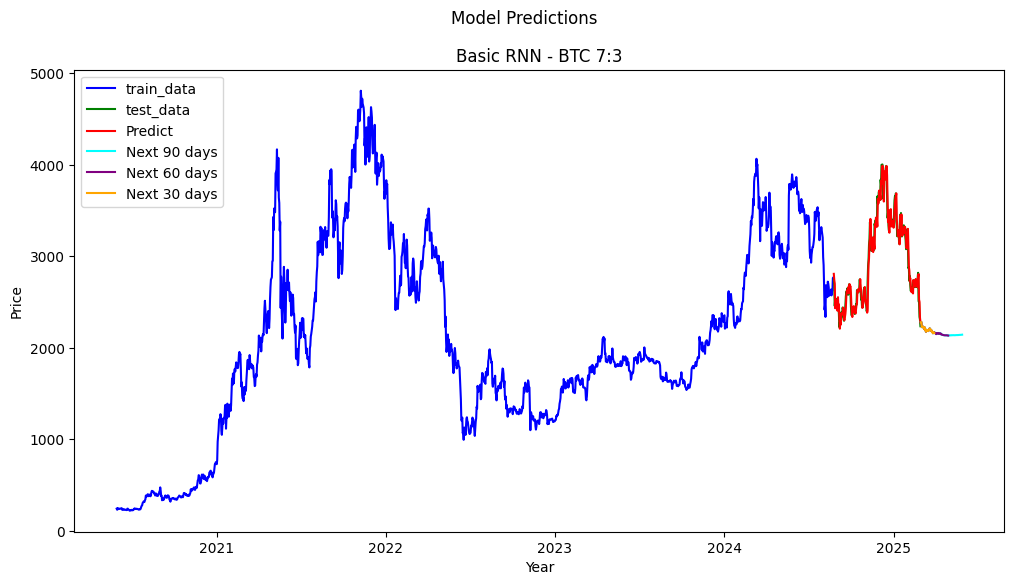

In [ ]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Predictions')

ax.plot(train_data.index[150:], train_data.Price[150:], label="train_data", color="b")
ax.plot(test_data.index, test_data.Price, label="test_data", color="g")
ax.plot(test_data.index, y_RNN_O, label="Predict", color="red")
ax.plot(future_dates_90, y_RNN_90, label="Next 90 days", color="cyan")
ax.plot(future_dates_60, y_RNN_60, label="Next 60 days", color="purple")
ax.plot(future_dates_30, y_RNN_30, label="Next 30 days", color="orange")

ax.legend()
ax.set_title("Basic RNN - BTC 7:3")
ax.set_xlabel("Year")
ax.set_ylabel("Price")

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Tính toán độ đo RMSE, MAPE và MSE
rmse = np.sqrt(mean_squared_error(test_data.Price, y_RNN_O))
mape = mean_absolute_percentage_error(test_data.Price, y_RNN_O) * 100
mse = mean_squared_error(test_data.Price, y_RNN_O)

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape, "%")
print("MSE:", mse)

RMSE: 103.80763724557404
MAPE: 2.6198000462289173 %
MSE: 10776.025550508692


In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
training_data_len = math.ceil(len(data) * 0.8)
train_data = data[:training_data_len].iloc[:, :2]
test_data = data[training_data_len:].iloc[:, :2]

In [ ]:
# Remove commas and convert 'Price' column to numeric
train_data['Price'] = train_data['Price'].str.replace(',', '').astype(float)
test_data['Price'] = test_data['Price'].str.replace(',', '').astype(float)

dataset_train = train_data.Price.values.reshape(-1, 1)
dataset_test = test_data.Price.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

# Tạo tập dữ liệu huấn luyện
X_train, y_train = [], []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Chuẩn bị dữ liệu kiểm tra
last_50_days_train = scaled_train[-50:]
full_test_input = np.concatenate((last_50_days_train, scaled_test), axis=0)
X_test = []
for i in range(50, len(full_test_input)):
    X_test.append(full_test_input[i-50:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Khởi tạo và huấn luyện mô hình RNN
regressor = Sequential()
regressor.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(1, activation=None))

regressor.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


C:\Users\Hii\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1440
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5330e-04
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0165e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4874e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1130e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8620e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5898e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014    
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011   
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5446e-04
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9383e-04
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4

In [ ]:
# Dự đoán với dữ liệu kiểm tra
y_RNN = regressor.predict(X_test)

# Dự đoán cho 30, 60, 90 ngày tiếp theo
def predict_future(days, last_X):
    future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=days, freq='D')
    y_future = []
    
    for date in future_dates:
        next_y = regressor.predict(last_X.reshape(1, -1, 1))
        y_future.append(next_y[0, 0])
        last_X = np.append(last_X[1:], next_y)
        
    y_future = np.array(y_future).reshape(-1, 1)
    y_future_scaled = scaler.inverse_transform(y_future)
    
    return future_dates, y_future_scaled

# Lấy giá trị cuối cùng của X_test làm điểm bắt đầu cho dự đoán
last_X = X_test[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30, y_RNN_30 = predict_future(30, last_X)
# Dự đoán cho 60 ngày tiếp theo sau 30 ngày dự đoán đầu tiên
future_dates_60, y_RNN_60 = predict_future(60, last_X)
# Dự đoán cho 90 ngày tiếp theo sau 60 ngày dự đoán đầu tiên
future_dates_90, y_RNN_90 = predict_future(90, last_X)

# Chuyển đổi các giá trị dự đoán về giá trị gốc
y_RNN_O = scaler.inverse_transform(y_RNN)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━

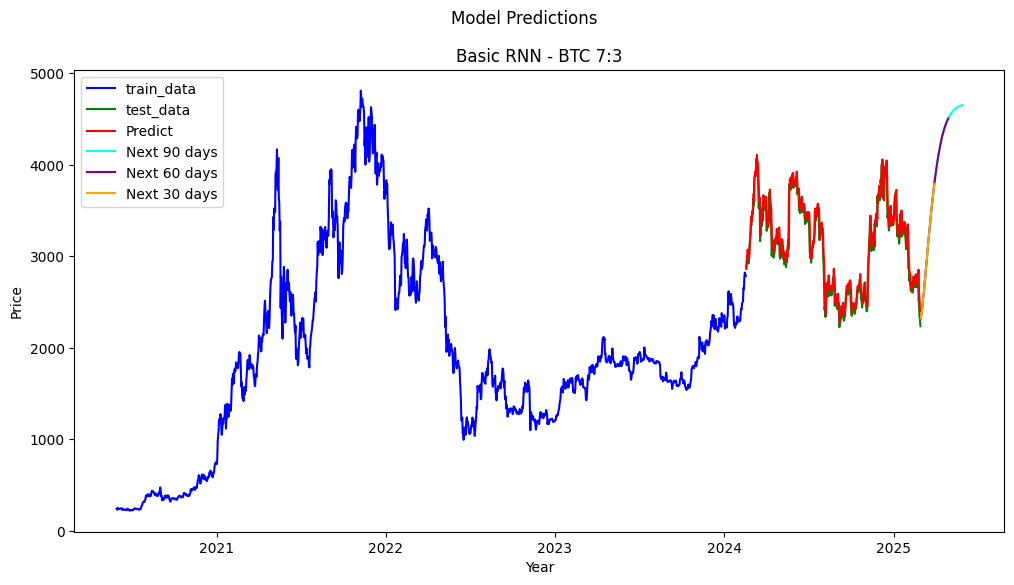

In [ ]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Predictions')

ax.plot(train_data.index[150:], train_data.Price[150:], label="train_data", color="b")
ax.plot(test_data.index, test_data.Price, label="test_data", color="g")
ax.plot(test_data.index, y_RNN_O, label="Predict", color="red")
ax.plot(future_dates_90, y_RNN_90, label="Next 90 days", color="cyan")
ax.plot(future_dates_60, y_RNN_60, label="Next 60 days", color="purple")
ax.plot(future_dates_30, y_RNN_30, label="Next 30 days", color="orange")

ax.legend()
ax.set_title("Basic RNN - BTC 7:3")
ax.set_xlabel("Year")
ax.set_ylabel("Price")

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Tính toán độ đo RMSE, MAPE và MSE
rmse = np.sqrt(mean_squared_error(test_data.Price, y_RNN_O))
mape = mean_absolute_percentage_error(test_data.Price, y_RNN_O) * 100
mse = mean_squared_error(test_data.Price, y_RNN_O)

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape, "%")
print("MSE:", mse)

RMSE: 117.14424800462656
MAPE: 2.8557438260248125 %
MSE: 13722.774840569455


## Ethereum Dataset


In [ ]:
file_path = "D:\\github_desktop\\Cryptocurrency-Price-Prediction\\Cryptocurrency\\Dataset\\XRP Historical Data.csv"

df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_values('Date', inplace=True)

# Assign to data variable for use in subsequent cells
data = df

### Chia 7:3


In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
training_data_len = math.ceil(len(data) * 0.7)
train_data = data[:training_data_len].iloc[:, :2]
test_data = data[training_data_len:].iloc[:, :2]

In [ ]:
# Convert 'Price' column to numeric by removing commas if needed
dataset_train = train_data.Price.values.reshape(-1, 1)
dataset_test = test_data.Price.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

# Tạo tập dữ liệu huấn luyện
X_train, y_train = [], []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Chuẩn bị dữ liệu kiểm tra
last_50_days_train = scaled_train[-50:]
full_test_input = np.concatenate((last_50_days_train, scaled_test), axis=0)
X_test = []
for i in range(50, len(full_test_input)):
    X_test.append(full_test_input[i-50:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Khởi tạo và huấn luyện mô hình RNN
regressor = Sequential()
regressor.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(1, activation=None))

regressor.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


C:\Users\Hii\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1897
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013    
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1605e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013    
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1468e-04
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5390e-04
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6690e-04
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

In [ ]:
# Dự đoán với dữ liệu kiểm tra
y_RNN = regressor.predict(X_test)

# Dự đoán cho 30, 60, 90 ngày tiếp theo
def predict_future(days, last_X):
    future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=days, freq='D')
    y_future = []
    
    for date in future_dates:
        next_y = regressor.predict(last_X.reshape(1, -1, 1))
        y_future.append(next_y[0, 0])
        last_X = np.append(last_X[1:], next_y)
        
    y_future = np.array(y_future).reshape(-1, 1)
    y_future_scaled = scaler.inverse_transform(y_future)
    
    return future_dates, y_future_scaled

# Lấy giá trị cuối cùng của X_test làm điểm bắt đầu cho dự đoán
last_X = X_test[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30, y_RNN_30 = predict_future(30, last_X)
# Dự đoán cho 60 ngày tiếp theo sau 30 ngày dự đoán đầu tiên
future_dates_60, y_RNN_60 = predict_future(60, last_X)
# Dự đoán cho 90 ngày tiếp theo sau 60 ngày dự đoán đầu tiên
future_dates_90, y_RNN_90 = predict_future(90, last_X)

# Chuyển đổi các giá trị dự đoán về giá trị gốc
y_RNN_O = scaler.inverse_transform(y_RNN)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

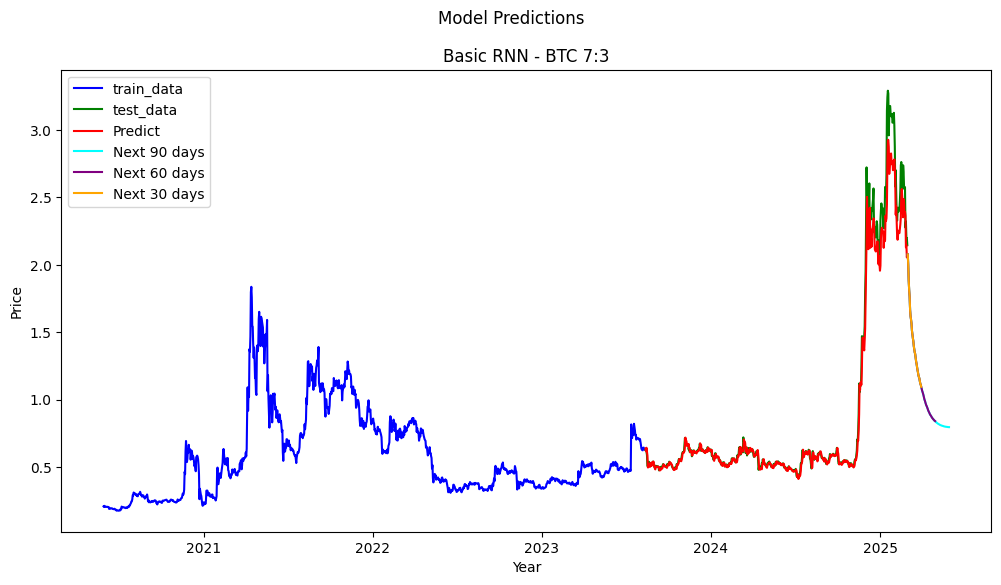

In [ ]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Predictions')

ax.plot(train_data.index[150:], train_data.Price[150:], label="train_data", color="b")
ax.plot(test_data.index, test_data.Price, label="test_data", color="g")
ax.plot(test_data.index, y_RNN_O, label="Predict", color="red")
ax.plot(future_dates_90, y_RNN_90, label="Next 90 days", color="cyan")
ax.plot(future_dates_60, y_RNN_60, label="Next 60 days", color="purple")
ax.plot(future_dates_30, y_RNN_30, label="Next 30 days", color="orange")

ax.legend()
ax.set_title("Basic RNN - BTC 7:3")
ax.set_xlabel("Year")
ax.set_ylabel("Price")

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Tính toán độ đo RMSE, MAPE và MSE
rmse = np.sqrt(mean_squared_error(test_data.Price, y_RNN_O))
mape = mean_absolute_percentage_error(test_data.Price, y_RNN_O) * 100
mse = mean_squared_error(test_data.Price, y_RNN_O)

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape, "%")
print("MSE:", mse)

RMSE: 0.10215148578542545
MAPE: 3.3916413230214943 %
MSE: 0.010434926048169977


### Chia 8:2


### Chia 9:1


In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
training_data_len = math.ceil(len(data) * 0.9)
train_data = data[:training_data_len].iloc[:, :2]
test_data = data[training_data_len:].iloc[:, :2]

In [ ]:
dataset_train = train_data.Price.values.reshape(-1, 1)
dataset_test = test_data.Price.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

# Tạo tập dữ liệu huấn luyện
X_train, y_train = [], []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Chuẩn bị dữ liệu kiểm tra
last_50_days_train = scaled_train[-50:]
full_test_input = np.concatenate((last_50_days_train, scaled_test), axis=0)
X_test = []
for i in range(50, len(full_test_input)):
    X_test.append(full_test_input[i-50:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Khởi tạo và huấn luyện mô hình RNN
regressor = Sequential()
regressor.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(1, activation=None))

regressor.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


C:\Users\Hii\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0781
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010   
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2014e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8960e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6102e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9266e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2925e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3891e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8496e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5825e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0466e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3228e-04
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7773e-04
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8707e-04
Epoch 15/100
26/26 ━━━━━━━━━━━━━

In [ ]:
# Dự đoán với dữ liệu kiểm tra
y_RNN = regressor.predict(X_test)

# Dự đoán cho 30, 60, 90 ngày tiếp theo
def predict_future(days, last_X):
    future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=days, freq='D')
    y_future = []
    
    for date in future_dates:
        next_y = regressor.predict(last_X.reshape(1, -1, 1))
        y_future.append(next_y[0, 0])
        last_X = np.append(last_X[1:], next_y)
        
    y_future = np.array(y_future).reshape(-1, 1)
    y_future_scaled = scaler.inverse_transform(y_future)
    
    return future_dates, y_future_scaled

# Lấy giá trị cuối cùng của X_test làm điểm bắt đầu cho dự đoán
last_X = X_test[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30, y_RNN_30 = predict_future(30, last_X)
# Dự đoán cho 60 ngày tiếp theo sau 30 ngày dự đoán đầu tiên
future_dates_60, y_RNN_60 = predict_future(60, last_X)
# Dự đoán cho 90 ngày tiếp theo sau 60 ngày dự đoán đầu tiên
future_dates_90, y_RNN_90 = predict_future(90, last_X)

# Chuyển đổi các giá trị dự đoán về giá trị gốc
y_RNN_O = scaler.inverse_transform(y_RNN)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

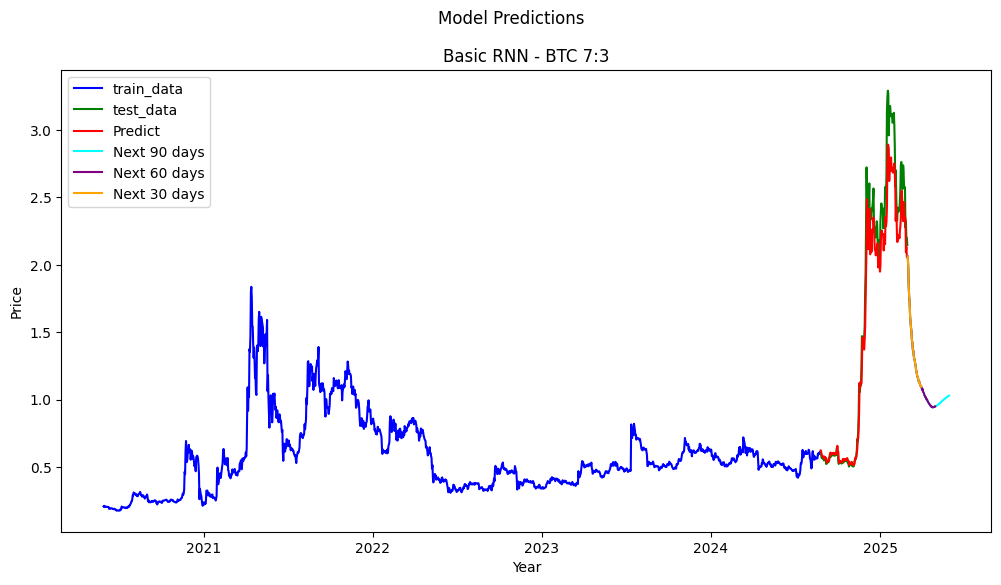

In [ ]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Predictions')

ax.plot(train_data.index[150:], train_data.Price[150:], label="train_data", color="b")
ax.plot(test_data.index, test_data.Price, label="test_data", color="g")
ax.plot(test_data.index, y_RNN_O, label="Predict", color="red")
ax.plot(future_dates_90, y_RNN_90, label="Next 90 days", color="cyan")
ax.plot(future_dates_60, y_RNN_60, label="Next 60 days", color="purple")
ax.plot(future_dates_30, y_RNN_30, label="Next 30 days", color="orange")

ax.legend()
ax.set_title("Basic RNN - BTC 7:3")
ax.set_xlabel("Year")
ax.set_ylabel("Price")

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Tính toán độ đo RMSE, MAPE và MSE
rmse = np.sqrt(mean_squared_error(test_data.Price, y_RNN_O))
mape = mean_absolute_percentage_error(test_data.Price, y_RNN_O) * 100
mse = mean_squared_error(test_data.Price, y_RNN_O)

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape, "%")
print("MSE:", mse)

RMSE: 0.18853317301110528
MAPE: 5.972583703131695 %
MSE: 0.035544757325635355


In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
training_data_len = math.ceil(len(data) * 0.8)
train_data = data[:training_data_len].iloc[:, :2]
test_data = data[training_data_len:].iloc[:, :2]

In [ ]:
dataset_train = train_data.Price.values.reshape(-1, 1)
dataset_test = test_data.Price.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

# Tạo tập dữ liệu huấn luyện
X_train, y_train = [], []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Chuẩn bị dữ liệu kiểm tra
last_50_days_train = scaled_train[-50:]
full_test_input = np.concatenate((last_50_days_train, scaled_test), axis=0)
X_test = []
for i in range(50, len(full_test_input)):
    X_test.append(full_test_input[i-50:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Khởi tạo và huấn luyện mô hình RNN
regressor = Sequential()
regressor.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(1, activation=None))

regressor.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


C:\Users\Hii\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1923
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0272
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9606e-04
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4479e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1938e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3187e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5271e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1155e-04
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0270e-04
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011    
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7186e-04
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/

In [ ]:
# Dự đoán với dữ liệu kiểm tra
y_RNN = regressor.predict(X_test)

# Dự đoán cho 30, 60, 90 ngày tiếp theo
def predict_future(days, last_X):
    future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=days, freq='D')
    y_future = []
    
    for date in future_dates:
        next_y = regressor.predict(last_X.reshape(1, -1, 1))
        y_future.append(next_y[0, 0])
        last_X = np.append(last_X[1:], next_y)
        
    y_future = np.array(y_future).reshape(-1, 1)
    y_future_scaled = scaler.inverse_transform(y_future)
    
    return future_dates, y_future_scaled

# Lấy giá trị cuối cùng của X_test làm điểm bắt đầu cho dự đoán
last_X = X_test[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30, y_RNN_30 = predict_future(30, last_X)
# Dự đoán cho 60 ngày tiếp theo sau 30 ngày dự đoán đầu tiên
future_dates_60, y_RNN_60 = predict_future(60, last_X)
# Dự đoán cho 90 ngày tiếp theo sau 60 ngày dự đoán đầu tiên
future_dates_90, y_RNN_90 = predict_future(90, last_X)

# Chuyển đổi các giá trị dự đoán về giá trị gốc
y_RNN_O = scaler.inverse_transform(y_RNN)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━

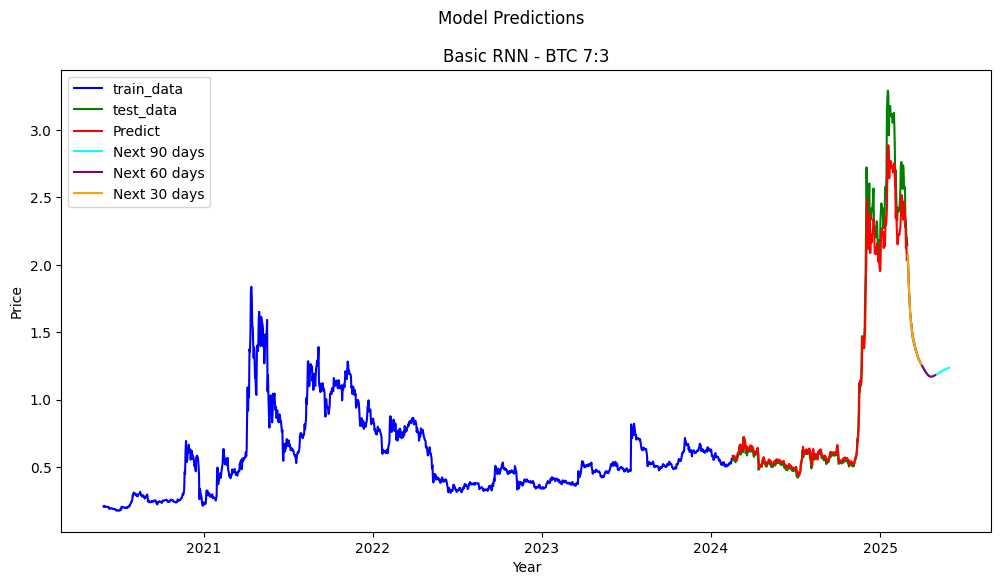

In [ ]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Predictions')

ax.plot(train_data.index[150:], train_data.Price[150:], label="train_data", color="b")
ax.plot(test_data.index, test_data.Price, label="test_data", color="g")
ax.plot(test_data.index, y_RNN_O, label="Predict", color="red")
ax.plot(future_dates_90, y_RNN_90, label="Next 90 days", color="cyan")
ax.plot(future_dates_60, y_RNN_60, label="Next 60 days", color="purple")
ax.plot(future_dates_30, y_RNN_30, label="Next 30 days", color="orange")

ax.legend()
ax.set_title("Basic RNN - BTC 7:3")
ax.set_xlabel("Year")
ax.set_ylabel("Price")

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Tính toán độ đo RMSE, MAPE và MSE
rmse = np.sqrt(mean_squared_error(test_data.Price, y_RNN_O))
mape = mean_absolute_percentage_error(test_data.Price, y_RNN_O) * 100
mse = mean_squared_error(test_data.Price, y_RNN_O)

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape, "%")
print("MSE:", mse)

RMSE: 0.13348841997689403
MAPE: 5.049562673479039 %
MSE: 0.017819158267927643


## XRP Dataset


In [ ]:
file_path = "D:\\github_desktop\\Cryptocurrency-Price-Prediction\\Cryptocurrency\\Dataset\\Bitcoin Historical Data.csv"

df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_values('Date', inplace=True)

# Assign to data variable for use in subsequent cells
data = df

### Chia 7:3


In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
training_data_len = math.ceil(len(data) * 0.7)
train_data = data[:training_data_len].iloc[:, :2]
test_data = data[training_data_len:].iloc[:, :2]

In [ ]:
# Remove commas and convert 'Price' column to numeric
train_data['Price'] = train_data['Price'].str.replace(',', '').astype(float)
test_data['Price'] = test_data['Price'].str.replace(',', '').astype(float)

dataset_train = train_data.Price.values.reshape(-1, 1)
dataset_test = test_data.Price.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

# Tạo tập dữ liệu huấn luyện
X_train, y_train = [], []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Chuẩn bị dữ liệu kiểm tra
last_50_days_train = scaled_train[-50:]
full_test_input = np.concatenate((last_50_days_train, scaled_test), axis=0)
X_test = []
for i in range(50, len(full_test_input)):
    X_test.append(full_test_input[i-50:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Khởi tạo và huấn luyện mô hình RNN
regressor = Sequential()
regressor.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(1, activation=None))

regressor.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


C:\Users\Hii\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3172
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7495e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3381e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6025e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4980e-04
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9106e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9359e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0937e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4748e-04
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9938e-04
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4984e-04
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9214e-04
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# Dự đoán với dữ liệu kiểm tra
y_RNN = regressor.predict(X_test)

# Dự đoán cho 30, 60, 90 ngày tiếp theo
def predict_future(days, last_X):
    future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=days, freq='D')
    y_future = []
    
    for date in future_dates:
        next_y = regressor.predict(last_X.reshape(1, -1, 1))
        y_future.append(next_y[0, 0])
        last_X = np.append(last_X[1:], next_y)
        
    y_future = np.array(y_future).reshape(-1, 1)
    y_future_scaled = scaler.inverse_transform(y_future)
    
    return future_dates, y_future_scaled

# Lấy giá trị cuối cùng của X_test làm điểm bắt đầu cho dự đoán
last_X = X_test[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30, y_RNN_30 = predict_future(30, last_X)
# Dự đoán cho 60 ngày tiếp theo sau 30 ngày dự đoán đầu tiên
future_dates_60, y_RNN_60 = predict_future(60, last_X)
# Dự đoán cho 90 ngày tiếp theo sau 60 ngày dự đoán đầu tiên
future_dates_90, y_RNN_90 = predict_future(90, last_X)

# Chuyển đổi các giá trị dự đoán về giá trị gốc
y_RNN_O = scaler.inverse_transform(y_RNN)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━

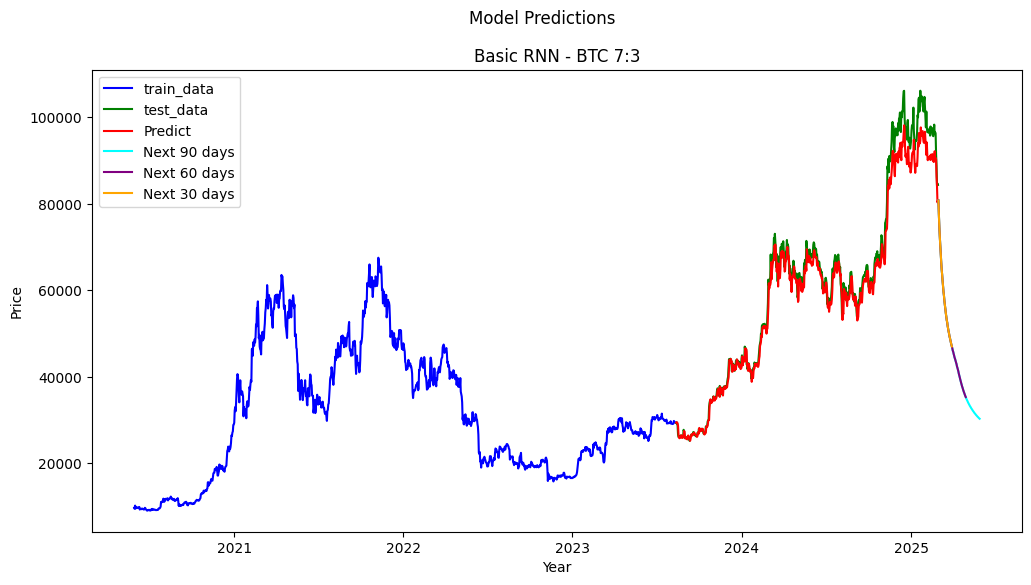

In [ ]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Predictions')

ax.plot(train_data.index[150:], train_data.Price[150:], label="train_data", color="b")
ax.plot(test_data.index, test_data.Price, label="test_data", color="g")
ax.plot(test_data.index, y_RNN_O, label="Predict", color="red")
ax.plot(future_dates_90, y_RNN_90, label="Next 90 days", color="cyan")
ax.plot(future_dates_60, y_RNN_60, label="Next 60 days", color="purple")
ax.plot(future_dates_30, y_RNN_30, label="Next 30 days", color="orange")

ax.legend()
ax.set_title("Basic RNN - BTC 7:3")
ax.set_xlabel("Year")
ax.set_ylabel("Price")

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Tính toán độ đo RMSE, MAPE và MSE
rmse = np.sqrt(mean_squared_error(test_data.Price, y_RNN_O))
mape = mean_absolute_percentage_error(test_data.Price, y_RNN_O) * 100
mse = mean_squared_error(test_data.Price, y_RNN_O)

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape, "%")
print("MSE:", mse)

RMSE: 3361.5351402705414
MAPE: 3.094450418939602 %
MSE: 11299918.499273688


### Chia 8:2


### Chia 9:1


In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
training_data_len = math.ceil(len(data) * 0.9)
train_data = data[:training_data_len].iloc[:, :2]
test_data = data[training_data_len:].iloc[:, :2]

In [ ]:
# Remove commas and convert 'Price' column to numeric if needed
if train_data['Price'].dtype == 'object':  # If the column contains strings
    train_data['Price'] = train_data['Price'].str.replace(',', '').astype(float)
if test_data['Price'].dtype == 'object':  # If the column contains strings
    test_data['Price'] = test_data['Price'].str.replace(',', '').astype(float)

dataset_train = train_data.Price.values.reshape(-1, 1)
dataset_test = test_data.Price.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

# Tạo tập dữ liệu huấn luyện
X_train, y_train = [], []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Chuẩn bị dữ liệu kiểm tra
last_50_days_train = scaled_train[-50:]
full_test_input = np.concatenate((last_50_days_train, scaled_test), axis=0)
X_test = []
for i in range(50, len(full_test_input)):
    X_test.append(full_test_input[i-50:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Khởi tạo và huấn luyện mô hình RNN
regressor = Sequential()
regressor.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(1, activation=None))

regressor.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


C:\Users\Hii\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0888
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2282e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6464e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7617e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2808e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2172e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6978e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4346e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8641e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9835e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3248e-04
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5841e-04
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8515e-04
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━

In [ ]:
# Dự đoán với dữ liệu kiểm tra
y_RNN = regressor.predict(X_test)

# Dự đoán cho 30, 60, 90 ngày tiếp theo
def predict_future(days, last_X):
    future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=days, freq='D')
    y_future = []
    
    for date in future_dates:
        next_y = regressor.predict(last_X.reshape(1, -1, 1))
        y_future.append(next_y[0, 0])
        last_X = np.append(last_X[1:], next_y)
        
    y_future = np.array(y_future).reshape(-1, 1)
    y_future_scaled = scaler.inverse_transform(y_future)
    
    return future_dates, y_future_scaled

# Lấy giá trị cuối cùng của X_test làm điểm bắt đầu cho dự đoán
last_X = X_test[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30, y_RNN_30 = predict_future(30, last_X)
# Dự đoán cho 60 ngày tiếp theo sau 30 ngày dự đoán đầu tiên
future_dates_60, y_RNN_60 = predict_future(60, last_X)
# Dự đoán cho 90 ngày tiếp theo sau 60 ngày dự đoán đầu tiên
future_dates_90, y_RNN_90 = predict_future(90, last_X)

# Chuyển đổi các giá trị dự đoán về giá trị gốc
y_RNN_O = scaler.inverse_transform(y_RNN)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━

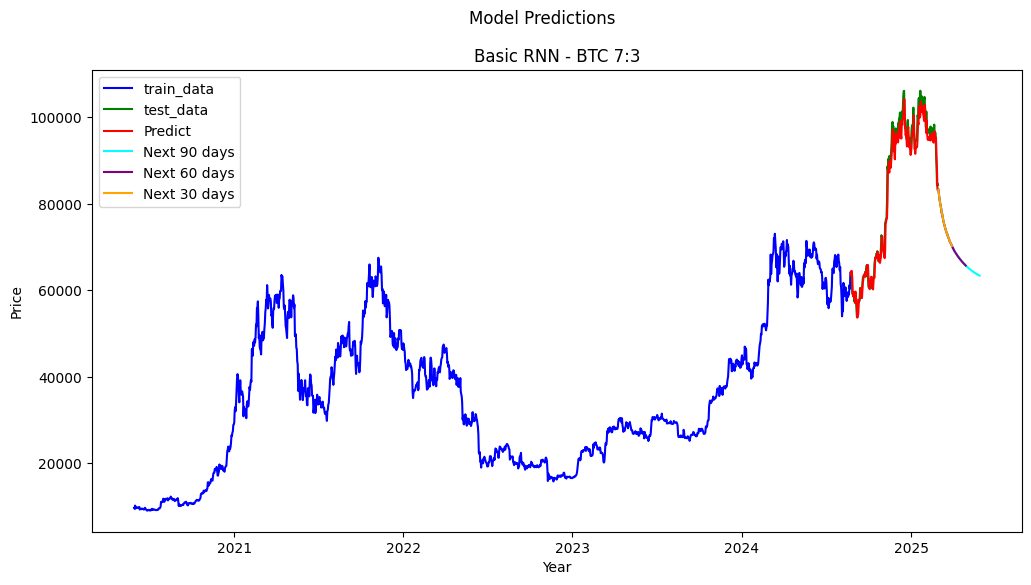

In [ ]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Predictions')

ax.plot(train_data.index[150:], train_data.Price[150:], label="train_data", color="b")
ax.plot(test_data.index, test_data.Price, label="test_data", color="g")
ax.plot(test_data.index, y_RNN_O, label="Predict", color="red")
ax.plot(future_dates_90, y_RNN_90, label="Next 90 days", color="cyan")
ax.plot(future_dates_60, y_RNN_60, label="Next 60 days", color="purple")
ax.plot(future_dates_30, y_RNN_30, label="Next 30 days", color="orange")

ax.legend()
ax.set_title("Basic RNN - BTC 7:3")
ax.set_xlabel("Year")
ax.set_ylabel("Price")

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Tính toán độ đo RMSE, MAPE và MSE
rmse = np.sqrt(mean_squared_error(test_data.Price, y_RNN_O))
mape = mean_absolute_percentage_error(test_data.Price, y_RNN_O) * 100
mse = mean_squared_error(test_data.Price, y_RNN_O)

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape, "%")
print("MSE:", mse)

RMSE: 2315.4356484047175
MAPE: 2.0354880649763896 %
MSE: 5361242.241903375


In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
training_data_len = math.ceil(len(data) * 0.8)
train_data = data[:training_data_len].iloc[:, :2]
test_data = data[training_data_len:].iloc[:, :2]

In [ ]:
# Remove commas and convert 'Price' column to numeric
train_data['Price'] = train_data['Price'].str.replace(',', '').astype(float)
test_data['Price'] = test_data['Price'].str.replace(',', '').astype(float)

dataset_train = train_data.Price.values.reshape(-1, 1)
dataset_test = test_data.Price.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

# Tạo tập dữ liệu huấn luyện
X_train, y_train = [], []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Chuẩn bị dữ liệu kiểm tra
last_50_days_train = scaled_train[-50:]
full_test_input = np.concatenate((last_50_days_train, scaled_test), axis=0)
X_test = []
for i in range(50, len(full_test_input)):
    X_test.append(full_test_input[i-50:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Khởi tạo và huấn luyện mô hình RNN
regressor = Sequential()
regressor.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dense(1, activation=None))

regressor.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100


C:\Users\Hii\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2832  
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2478e-04
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2064e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7690e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8789e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9191e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5722e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0555e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0176e-04
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4935e-04
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9957e-04
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0699e-04
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━

In [ ]:
# Dự đoán với dữ liệu kiểm tra
y_RNN = regressor.predict(X_test)

# Dự đoán cho 30, 60, 90 ngày tiếp theo
def predict_future(days, last_X):
    future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=days, freq='D')
    y_future = []
    
    for date in future_dates:
        next_y = regressor.predict(last_X.reshape(1, -1, 1))
        y_future.append(next_y[0, 0])
        last_X = np.append(last_X[1:], next_y)
        
    y_future = np.array(y_future).reshape(-1, 1)
    y_future_scaled = scaler.inverse_transform(y_future)
    
    return future_dates, y_future_scaled

# Lấy giá trị cuối cùng của X_test làm điểm bắt đầu cho dự đoán
last_X = X_test[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30, y_RNN_30 = predict_future(30, last_X)
# Dự đoán cho 60 ngày tiếp theo sau 30 ngày dự đoán đầu tiên
future_dates_60, y_RNN_60 = predict_future(60, last_X)
# Dự đoán cho 90 ngày tiếp theo sau 60 ngày dự đoán đầu tiên
future_dates_90, y_RNN_90 = predict_future(90, last_X)

# Chuyển đổi các giá trị dự đoán về giá trị gốc
y_RNN_O = scaler.inverse_transform(y_RNN)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━

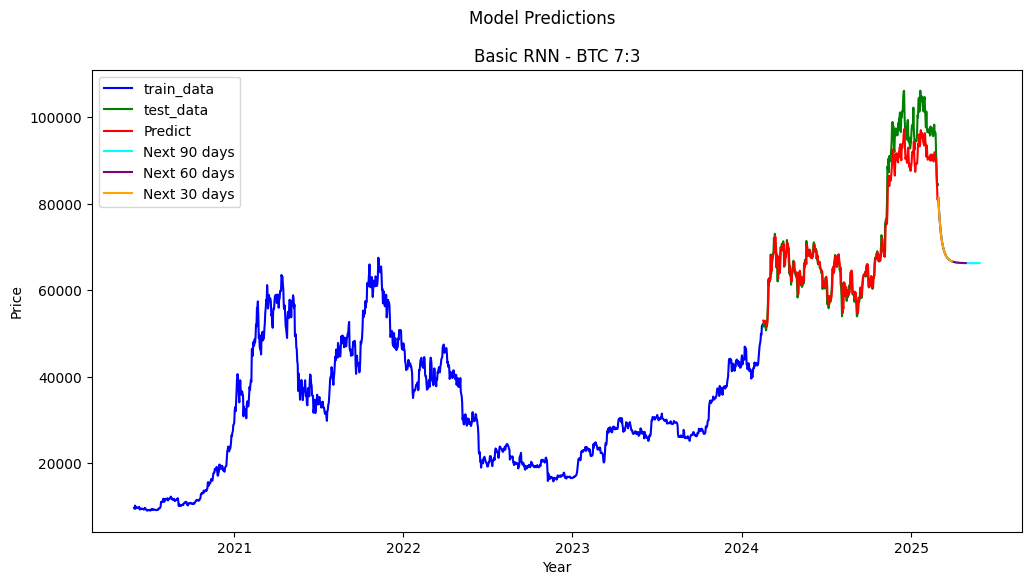

In [ ]:
# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Model Predictions')

ax.plot(train_data.index[150:], train_data.Price[150:], label="train_data", color="b")
ax.plot(test_data.index, test_data.Price, label="test_data", color="g")
ax.plot(test_data.index, y_RNN_O, label="Predict", color="red")
ax.plot(future_dates_90, y_RNN_90, label="Next 90 days", color="cyan")
ax.plot(future_dates_60, y_RNN_60, label="Next 60 days", color="purple")
ax.plot(future_dates_30, y_RNN_30, label="Next 30 days", color="orange")

ax.legend()
ax.set_title("Basic RNN - BTC 7:3")
ax.set_xlabel("Year")
ax.set_ylabel("Price")

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Tính toán độ đo RMSE, MAPE và MSE
rmse = np.sqrt(mean_squared_error(test_data.Price, y_RNN_O))
mape = mean_absolute_percentage_error(test_data.Price, y_RNN_O) * 100
mse = mean_squared_error(test_data.Price, y_RNN_O)

# In kết quả
print("RMSE:", rmse)
print("MAPE:", mape, "%")
print("MSE:", mse)

RMSE: 3912.1289068585243
MAPE: 3.3047035200119126 %
MSE: 15304752.583878072
